In [12]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from IPython.display import Image
import pydot

In [13]:
test_dir = "dataset/test"
train_dir = "dataset/train"

height = 32
width = 32
batch_size = 500

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    seed = 512,
    image_size = (height, width),
    batch_size = batch_size
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    seed = 512,
    image_size = (height, width),
    batch_size = batch_size
)

print(f"Training Classes: {train_ds.class_names}")
print(f"Testing Classes: {test_ds.class_names}")

Found 100000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.
Training Classes: ['FAKE', 'REAL']
Testing Classes: ['FAKE', 'REAL']


In [14]:
def plot_metrics(history, metric):
    plt.plot(history.history[metric], label = metric)
    plt.plot(history.history['val_' + metric], label='val_' + metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.show()
    
# Constant values that will be shared by all the models
test_true_classes = np.concatenate([y for x, y in test_ds], axis = 0)  # Get true labels
class_names = ['FAKE', 'REAL']
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'test_loss', patience = 10, restore_best_weights = True) 

In [15]:
# Building the Transfer Learning model using ResNet50
ResNet_base_model = tf.keras.applications.ResNet50(
    include_top = False, 
    weights = 'imagenet', 
    input_shape = (height, width, 3),
    pooling = 'max'
)
ResNet_base_model.trainable = True

# Create a new model on top of the ResNet50 base
inputs = tf.keras.Input(shape = (height, width, 3))
x = ResNet_base_model(inputs, training = False)
x = BatchNormalization(axis = -1, momentum = 0.99, epsilon = 0.001)(x)
x = Dense(256, 
          kernel_regularizer = regularizers.l2(0.01), 
          activity_regularizer = regularizers.l1(0.01), 
          bias_regularizer = regularizers.l1(0.01),
          activation = 'relu')(x)
x = Dropout(rate = .4, seed = 512)(x)       
x = Dense(64, activation = 'relu')(x)
outputs = Dense(1, activation = 'sigmoid')(x)
ResNet_model = tf.keras.Model(inputs, outputs)

# Compile the model
ResNet_model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = .001),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Summary of the model
ResNet_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,136,961 (92.08 MB)

 Trainable params: 24,079,745 (91.86 MB)

 Non-trainable params: 57,216 (223.50 KB)

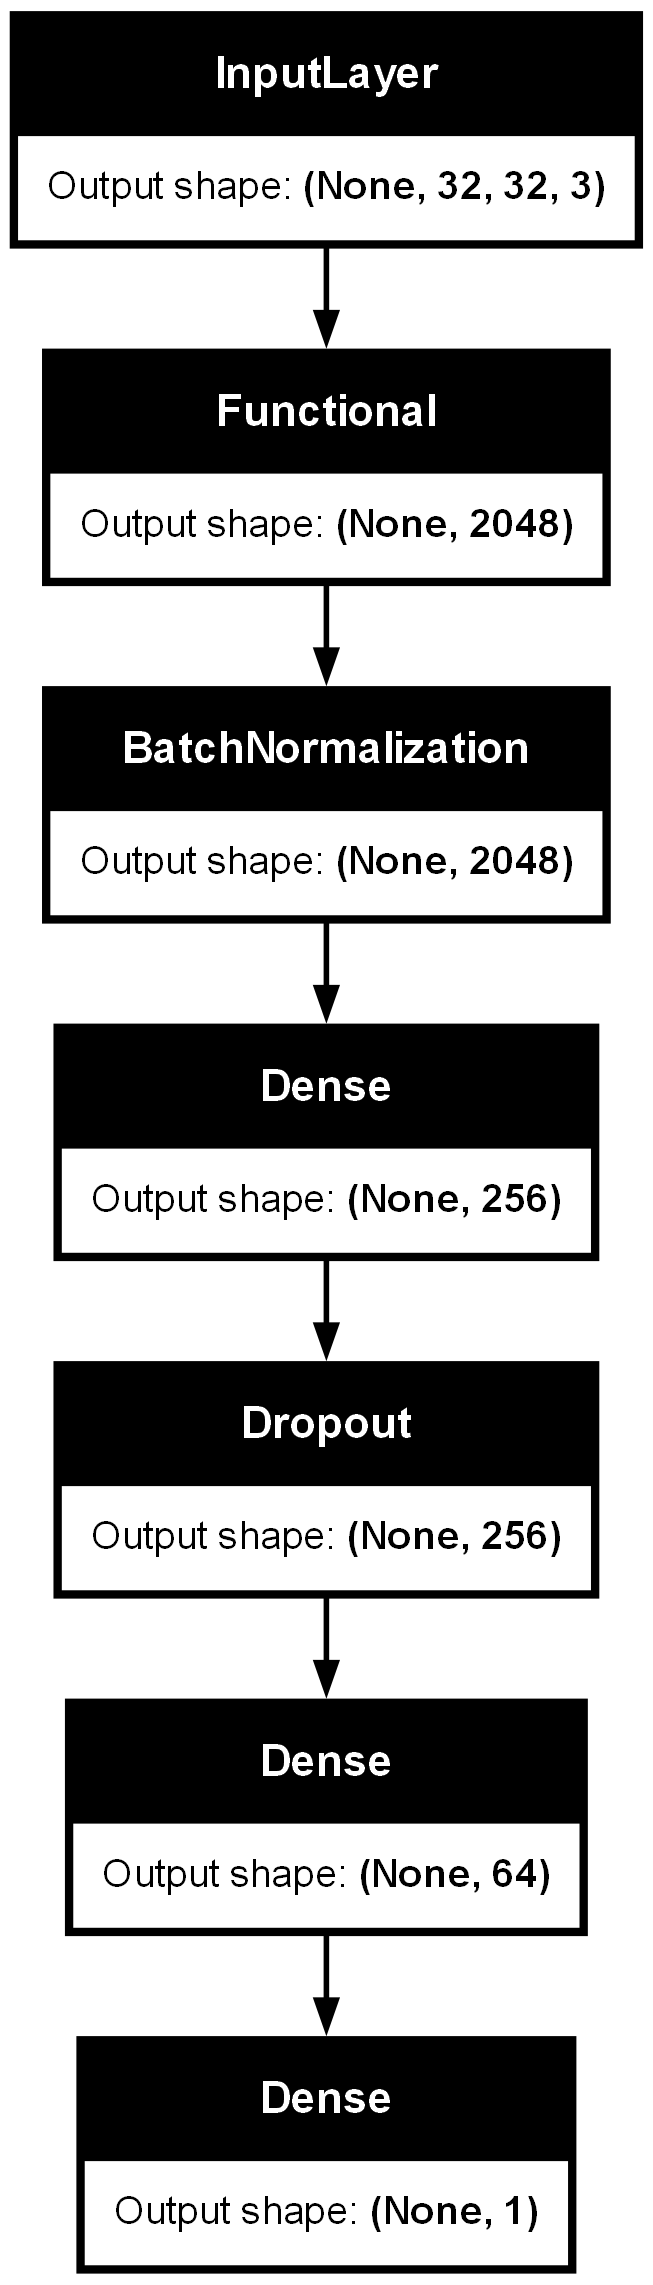

In [16]:
# Visualize the ResNet model architecture
tf.keras.utils.plot_model(ResNet_model, show_shapes = True, to_file = 'ResNet_model.png')
Image('ResNet_model.png')

In [17]:
# Train the Transfer Learning model
print("Starting training with Transfer Learning using ResNet50...")
ResNet_model_history = ResNet_model.fit(
    train_ds,
    validation_data = test_ds,
    epochs = 3,
    verbose = 1,
    callbacks = [early_stopping]
)
print("Transfer Learning training finished.")

Starting training with Transfer Learning using ResNet50...
Epoch 1/3
110/200 ━━━━━━━━━━━━━━━━━━━━ 13:42 9s/step - accuracy: 0.5034 - loss: 72.9275 - precision_1: 0.5021 - recall_1: 0.8349

KeyboardInterrupt: 

In [ ]:
# Evaluate the model on the test dataset
val_loss, val_accuracy, val_precision, val_recall = ResNet_model.evaluate(test_ds)

# Print the metrics
print(f"Val Loss: {val_loss:.4f}")
print(f"Val Accuracy: {val_accuracy:.4f}")
print(f"Val Precision: {val_precision:.4f}")
print(f"Val Recall: {val_recall:.4f}")

In [ ]:
# Plot error rates and metric rates
plot_metrics(ResNet_model_history, 'loss')
plot_metrics(ResNet_model_history, 'accuracy')
plot_metrics(ResNet_model_history, 'precision')
plot_metrics(ResNet_model_history, 'recall')

In [ ]:
ResNet_model.save('restnet_model_h5.h5')


In [ ]:
%cd /kaggle/working
from IPython.display import FileLink
FileLink('restnet_model_h5.h5')

In [ ]:
# Building the Transfer Learning model using VGG16
VGG_base_model = tf.keras.applications.VGG16(
    include_top = False, 
    weights = 'imagenet', 
    input_shape = (height, width, 3),
    pooling = 'max'
)
VGG_base_model.trainable = True

# Create a new model on top of the VGG16 base
inputs = tf.keras.Input(shape = (height, width, 3))
x = VGG_base_model(inputs, training = False)
x = BatchNormalization(axis = -1, momentum = 0.99, epsilon = 0.001)(x)
x = Dense(256, 
          kernel_regularizer = regularizers.l2(0.01), 
          activity_regularizer = regularizers.l1(0.01), 
          bias_regularizer = regularizers.l1(0.01),
          activation = 'relu')(x)
x = Dropout(rate = .4, seed = 512)(x)       
x = Dense(64, activation = 'relu')(x)
outputs = Dense(1, activation = 'sigmoid')(x)
VGG_model = tf.keras.Model(inputs, outputs)

# Compile the Transfer Learning model
VGG_model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = .001),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Build the Transfer Learning model so we can see a summary
VGG_model.summary()

In [ ]:
# Visualize the VGG model architecture
tf.keras.utils.plot_model(VGG_model, show_shapes = True, to_file = 'VGG_model.png')
Image('VGG_model.png')

In [ ]:
print("Starting training with Transfer Learning using VGG16...")
VGG_model_history = VGG_model.fit(
    train_ds,
    validation_data = test_ds,
    epochs = 100,
    verbose = 1,
    callbacks = [early_stopping]
)
print("Transfer Learning training finished.")

In [ ]:
# Evaluate the model on the test dataset
val_loss, val_accuracy, val_precision, val_recall = VGG_model.evaluate(test_ds)

# Print the metrics
print(f"Val Loss: {val_loss:.4f}")
print(f"Val Accuracy: {val_accuracy:.4f}")
print(f"Val Precision: {val_precision:.4f}")
print(f"Val Recall: {val_recall:.4f}")

In [ ]:
# Plot error rates and metric rates
plot_metrics(VGG_model_history, 'loss')
plot_metrics(VGG_model_history, 'accuracy')
plot_metrics(VGG_model_history, 'precision_1')
plot_metrics(VGG_model_history, 'recall_1')

In [ ]:
VGG_model.save('VGG_model_h5.h5')


In [ ]:
%cd /kaggle/working
from IPython.display import FileLink
FileLink('VGG_model_h5.h5')

In [ ]:
# Building the Transfer Learning model using EfficientNetV2B0
EfficientNet_base_model = tf.keras.applications.EfficientNetV2B0(
    include_top = False, 
    weights = 'imagenet', 
    input_shape = (height, width, 3),
    pooling = 'max'
)
EfficientNet_base_model.trainable = True

# Create a new model on top of the EfficientNet base
inputs = tf.keras.Input(shape = (height, width, 3))
x = EfficientNet_base_model(inputs, training = False)
x = BatchNormalization(axis = -1, momentum = 0.99, epsilon = 0.001)(x)
x = Dense(256, 
          kernel_regularizer = regularizers.l2(0.01), 
          activity_regularizer = regularizers.l1(0.01), 
          bias_regularizer = regularizers.l1(0.01),
          activation = 'relu')(x)
x = Dropout(rate = .4, seed = 512)(x)       
x = Dense(64, activation = 'relu')(x)
outputs = Dense(1, activation = 'sigmoid')(x)
EfficientNet_model = tf.keras.Model(inputs, outputs)

# Compile the Transfer Learning model
EfficientNet_model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = .001),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Build the Transfer Learning model so we can see a summary
EfficientNet_model.summary()

In [ ]:
# Visualize the EfficientNet model architecture
tf.keras.utils.plot_model(EfficientNet_model, show_shapes = True, to_file = 'EfficientNet_model.png')
Image('EfficientNet_model.png')

In [ ]:
# Finally, train the Transfer Learning model
print("Starting training with Transfer Learning using EfficientNet...")
EfficientNet_model_history = EfficientNet_model.fit(
    train_ds,
    validation_data = test_ds,
    epochs = 100,
    verbose = 1,
    callbacks = [early_stopping]
)
print("Transfer Learning training finished.")

In [ ]:
# Evaluate the model on the test dataset
val_loss, val_accuracy, val_precision, val_recall = EfficientNet_model.evaluate(test_ds)

# Print the metrics
print(f"Val Loss: {val_loss:.4f}")
print(f"Val Accuracy: {val_accuracy:.4f}")
print(f"Val Precision: {val_precision:.4f}")
print(f"Val Recall: {val_recall:.4f}")

In [ ]:
# Plot error rates and metric rates
plot_metrics(EfficientNet_model_history, 'loss')
plot_metrics(EfficientNet_model_history, 'accuracy')
plot_metrics(EfficientNet_model_history, 'precision_2')
plot_metrics(EfficientNet_model_history, 'recall_2')

In [ ]:
EfficientNet_model.save("EfficientNet_model.h5")


In [ ]:
# Building the Transfer Learning model using MobileNetV3
MobileNet_base_model = tf.keras.applications.MobileNetV3Small(
    include_top = False, 
    weights = 'imagenet', 
    input_shape = (height, width, 3),
    pooling = 'max'
)
MobileNet_base_model.trainable = True

# Create a new model on top of the MobileNet base
inputs = tf.keras.Input(shape = (height, width, 3))
x = MobileNet_base_model(inputs, training = False)
x = BatchNormalization(axis = -1, momentum = 0.99, epsilon = 0.001)(x)
x = Dense(256, 
          kernel_regularizer = regularizers.l2(0.01), 
          activity_regularizer = regularizers.l1(0.01), 
          bias_regularizer = regularizers.l1(0.01),
          activation = 'relu')(x)
x = Dropout(rate = .4, seed = 512)(x)       
x = Dense(64, activation = 'relu')(x)
outputs = Dense(1, activation = 'sigmoid')(x)
MobileNet_model = tf.keras.Model(inputs, outputs)

# Compile the Transfer Learning model
MobileNet_model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Build the Transfer Learning model so we can see a summary
MobileNet_model.summary()

In [ ]:
# Visualize the MobileNet model architecture
tf.keras.utils.plot_model(MobileNet_model, show_shapes = True, to_file = 'MobileNet_model.png')
Image('MobileNet_model.png')

In [ ]:
# Finally, train the Transfer Learning model
print("Starting training with Transfer Learning using MobileNet...")
MobileNet_model_history = MobileNet_model.fit(
    train_ds,
    validation_data = test_ds,
    epochs = 100,
    verbose = 1,
    callbacks = [early_stopping]
)
print("Transfer Learning training finished.")

In [ ]:
# Evaluate the model on the test dataset
val_loss, val_accuracy, val_precision, val_recall = MobileNet_model.evaluate(test_ds)

# Print the metrics
print(f"Val Loss: {val_loss:.4f}")
print(f"Val Accuracy: {val_accuracy:.4f}")
print(f"Val Precision: {val_precision:.4f}")
print(f"Val Recall: {val_recall:.4f}")

In [ ]:
# Plot error rates and metric rates
plot_metrics(MobileNet_model_history, 'loss')
plot_metrics(MobileNet_model_history, 'accuracy')
plot_metrics(MobileNet_model_history, 'precision_3')
plot_metrics(MobileNet_model_history, 'recall_3')

In [ ]:
# Save the MobileNet model
MobileNet_model.save("MobileNet_model.h5")